In [7]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 989
    display(IFrame(src, width, height))

# Lecture 20 – Confidence Intervals, Center and Spread

## DSC 10, Spring 2022

### Announcements

- Lab 6 is due **tomorrow at 11:59pm**.
- HW 6 is due **Sat at 11:59pm**.
- Final project will be released this week.
    - [Get a partner lined up][partner]! 
    - If you work with a partner, you **must** follow these [pair programming guidelines](https://dsc10.com/pair-programming)
    
[partner]: https://docs.google.com/spreadsheets/d/1bikGY4L2mvnlEY3Gux1A3OqomRDh7Z00R___CRJZj-A/edit#gid=176865528

### Agenda

- Interpreting confidence intervals.
- Confidence intervals for hypothesis testing.
- Mean and median.
- Standard deviation.

## Interpreting confidence intervals

Let's rerun our code from last time to compute a confidence interval:

In [11]:
np.random.seed(23) # Magic to ensure that we get the same results every time this code is run

population = bpd.read_csv('data/2020_salaries.csv').get(['TotalWages'])
population_median = population.get('TotalWages').median()
my_sample = population.sample(500)
sample_median = my_sample.get('TotalWages').median()

In [14]:
# bootstrap the sample medians
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    resample = my_sample.sample(500, replace=True)
    median = resample.get('TotalWages').median()
    boot_medians = np.append(boot_medians, median)

In [18]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)

# Therefore, our interval is
[left, right]

[64871.0, 75032.0]

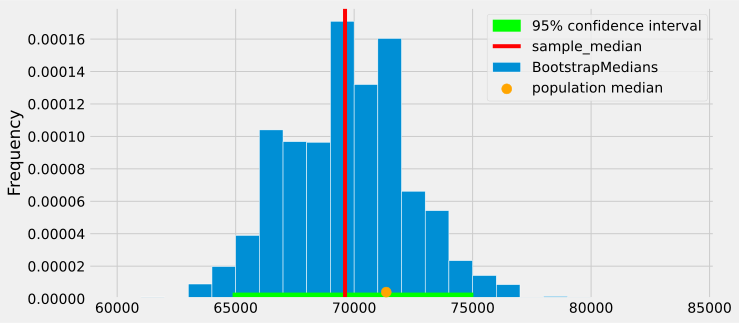

In [19]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=12, label='95% confidence interval');
plt.axvline(sample_median, c='r', label='sample_median');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(3)
plt.legend();

### Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval.
- We're pretty confident that the true median does, too.
- How confident should we be about this? **What does a 95% confidence interval mean?**

### Capturing the true value

- Consider the process of:
    - Collecting a **new original sample** from the population,
    - Bootstrap resampling from it many times, computing the statistic (e.g. median) in each resample, and
    - Constructing a new 95% confidence interval.
- What a 95% confidence level states is that **approximately 95% of the time, the intervals you create through this process will contain the true population parameter**.
- The confidence is in **the process** that generates the interval.

### Many confidence intervals

- We repeated the process outlined on the previous slide 200 times, to come up with 200 confidence intervals.
    - We did this in advance and saved the results to a file to save time.
- The resulting CIs are stored in the array `many_cis` below.

In [5]:
many_cis = np.load('data/many_cis.npy')
many_cis

array([[64954.125 , 76985.0625],
       [64961.    , 76063.    ],
       [64757.5   , 74301.9625],
       [60506.9625, 74611.    ],
       [67588.    , 78229.9375],
       [61812.    , 73945.    ],
       [68924.5   , 80349.9625],
       [71431.925 , 81088.    ],
       [64406.275 , 75554.775 ],
       [67690.45  , 77775.75  ],
       [68130.475 , 78620.325 ],
       [64909.4625, 77356.5   ],
       [59224.7   , 70675.7   ],
       [66391.    , 77960.8875],
       [66319.7375, 77615.6125],
       [67083.1125, 79363.3875],
       [61795.7   , 73934.0125],
       [63061.4   , 73949.7625],
       [65488.    , 76505.4375],
       [66329.875 , 77803.1375],
       [66698.1   , 77587.3375],
       [61847.625 , 72512.8375],
       [64069.5   , 75304.    ],
       [64652.    , 74501.    ],
       [67677.3125, 78969.275 ],
       [69069.05  , 78878.    ],
       [71551.    , 81234.    ],
       [61816.    , 73032.125 ],
       [66691.    , 76750.6   ],
       [63845.5   , 75093.    ],
       [62

In the visualization below,
- The orange line represents the population parameter. **This is not random.**
- Each green line represents a separate confidence interval, created using the specified process.
- Most of these confidence intervals contain the true parameter – but not all!

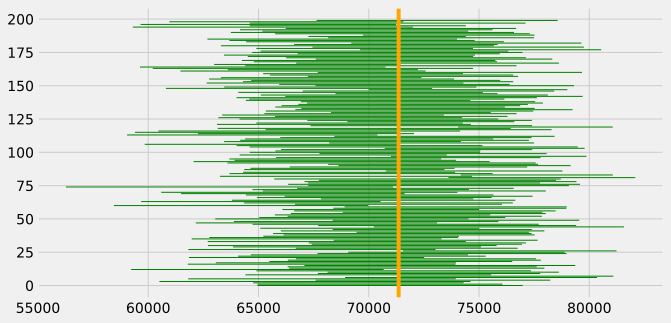

In [20]:
plt.figure(figsize=(10, 5))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
plt.axvline(x=population_median, color='orange');

### Which confidence intervals don't contain the true parameter?

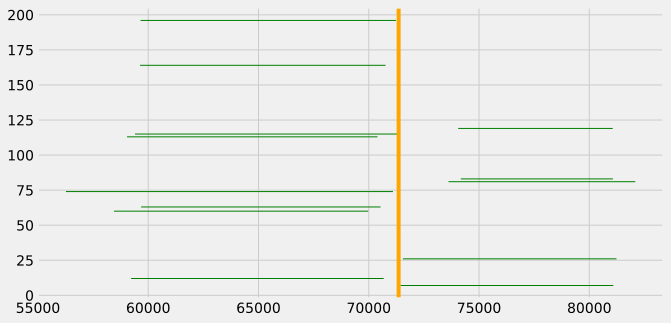

In [21]:
plt.figure(figsize=(10, 5))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='orange');

In [22]:
count_outside

13

- 13 of my 200 confidence intervals didn't contain the true parameter.
- That means 187/200, or 93.5% of them, did.
    - This is pretty close to 95%!
- In reality, you will have **no way of knowing if your confidence interval contains the true parameter**, since you have no way of knowing if your original sample is good.

### Confidence Tradeoffs

- If I choose 95% confidence, about 5% of my samples will be "unlucky".
    - When I use an unlucky sample to make my CI, the CI won't contain the population parameter.
- If I choose 80% confidence, about 20% of my samples will be unlucky.
    - But, my confidence interval will be narrower, which means I'm making a more precise estimation.
- How do I have high confidence and high precision?
    - Take a big sample!

### Misinterpreting confidence intervals

- Confidence intervals are confusing. Here are a few common misconceptions.

In [23]:
# Our interval
[left, right]

[64871.0, 75032.0]

- It is **not true** that this interval contains 95% of all salaries.
- Instead, it is true that this interval contains 95% of all bootstrapped **median** salaries.

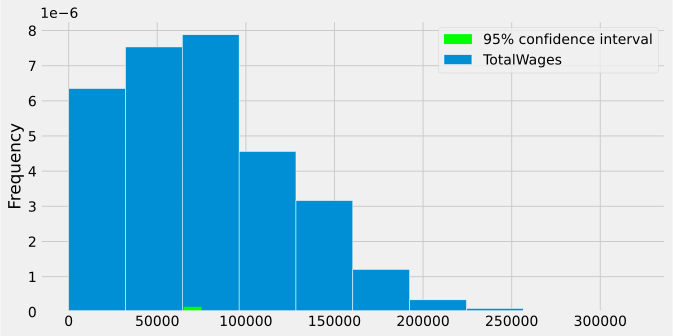

In [24]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=10, label='95% confidence interval');
plt.legend();

### Misinterpreting confidence intervals

In [25]:
# Our interval
[left, right]

[64871.0, 75032.0]

- It is **not true** that there is a 95% chance that the interval above contains the population parameter.
    - Once I have a sample, the interval is (essentially) fixed.
    - Either the population parameter is in the interval, or it is not. There is no randomness involved.
- Remember that the 95% confidence is in the process that created an interval.
    - This process (sampling, then bootstrapping, then creating an interval) has a roughly 95% chance of creating a good interval.
    - 95% confidence needs all three steps. Can't skip the first one!

In [26]:
show_confidence_interval_slides()

### Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We only had to collect a single sample from the population to get the (approximate) distribution of the sample median.
- But it has limitations:
    - It is not good for sensitive statistics, like the max or min.
    - It requires the sample to be a good approximation of population.
        - If our original sample was not representative of the population, the resulting bootstrapped samples will also not be representative of the population.

### Example: estimating the max of a population

Suppose we want to estimate the maximum salary of all San Diego city employees, given just a single sample `my_sample`.

In [39]:
# The true maximum salary in the population
population_max = population.get('TotalWages').max()
population_max

320699

### Running the bootstrap

- We want to estimate the maximum number in the population.
- Our estimate will be the max in the sample.
- We run the bootstrap:

In [40]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):

    resample = my_sample.sample(my_sample.shape[0], replace=True)
    
    boot_max = resample.get('TotalWages').max()
    
    boot_maxes = np.append(boot_maxes, boot_max)

In [41]:
boot_maxes

array([230087., 257062., 257062., ..., 257062., 257062., 257062.])

### Visualize

The bootstrap distribution doesn't capture the population maximum (orange dot) of 320699. Why not? 🤔

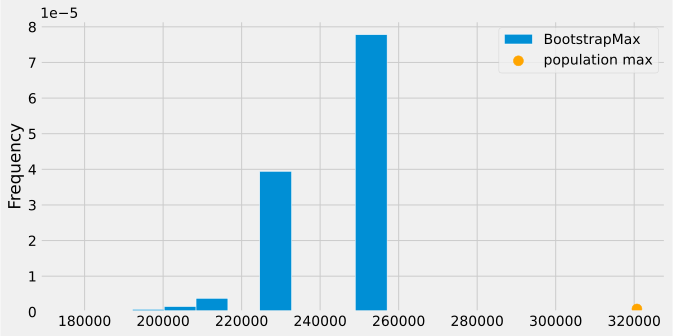

In [42]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='orange', s=100, label='population max')
plt.legend();

### Why did that happen?

In [43]:
my_sample.get('TotalWages').max()

257062

- The largest value in our original sample was 257062. 
- Therefore, the largest value in any bootstrapped sample is at most 257062.
- Generally, the bootstrap works better for measures of central tendency or variation (means, medians, variances) than it does for extremas (maxes and mins).

## Confidence intervals and hypothesis testing

In [27]:
show_confidence_interval_slides()

### Using a confidence interval for hypothesis testing

It turns out that we can use bootstrapped confidence intervals for hypothesis testing!

- **Null hypothesis**: The population parameter is equal to some value, $x$.
- **Alternative hypothesis**: The population parameter is not equal to $x$.
- Cutoff for p-value: p%.
- Strategy:
    - Construct a (100-p)% confidence interval for the population parameter.
    - If $x$ is not in the interval, reject the null hypothesis.
    - If $x$ is in the interval, our results are consistent with the null (fail to reject it).

### Example: Fire-Rescue Department 🚒

In [28]:
population = bpd.read_csv('data/2020_salaries.csv')
fire_rescue_population = population[population.get('DepartmentOrSubdivision') == 'Fire-Rescue']
fire_rescue_population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
3,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
4,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
5,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12556,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
12560,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
12570,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN


### Just a sample
- Suppose we only have access to a sample of 300 Fire-Rescue Department workers.
- We want to understand the median salary of *all* Fire-Rescue Department workers.
- **Null hypothesis**: The median salary of Fire-Rescue Department workers is the same as the median of all San Diego city employee salaries, \$71,354.50.
- **Alternative hypothesis**: The median salary of Fire-Rescue Department workers is not the same as the median of all San Diego city employee salaries.
- We'll use a significance level (i.e. p-value cutoff) of 0.01, to be *really* sure.

In [29]:
# The median salary of all City of SD employees, in all departments
population_median = population.get('TotalWages').median()
population_median

71354.5

In [30]:
fire_rescue_sample = fire_rescue_population.sample(300, replace=False)
fire_rescue_sample

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
3486,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
4907,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
2129,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
6825,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
166,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
9531,2020,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN


### Testing the hypotheses
- Since we're using a significance level of 0.01 = 1%, we need a 99% confidence interval for the median salary of Fire-Rescue Department workers.
- To construct a confidence interval, we'll bootstrap to compute many sample medians, and we'll find the middle 99% of the distribution of bootstrapped medians using `np.percentile`.

In [31]:
n_resamples = 500
fire_rescue_medians = np.array([])
for i in range(n_resamples):
    # Resample from fire_rescue_sample
    resample = fire_rescue_sample.sample(300, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Add it to our array of bootstrapped medians
    fire_rescue_medians = np.append(fire_rescue_medians, median)

In [32]:
fire_rescue_medians

array([ 98948.,  98948., 102988., ...,  94645.,  92561.,  97906.])

### Finding the interval

In [33]:
fire_left = np.percentile(fire_rescue_medians, 0.5)
fire_left

87637.535

In [34]:
fire_right = np.percentile(fire_rescue_medians, 99.5)
fire_right

106885.465

In [35]:
# Resulting interval
[fire_left, fire_right]

[87637.535, 106885.465]

Is \$71,354.50 in this interval? ❌

### Conclusion of the hypothesis test
- Since our 99% confidence interval did not contain the median of all San Diego city employee salaries, \$71,354.50, we reject the null.
- Fire-Rescue Department workers do not have the same median salary as other city employees.
- We can't say why.

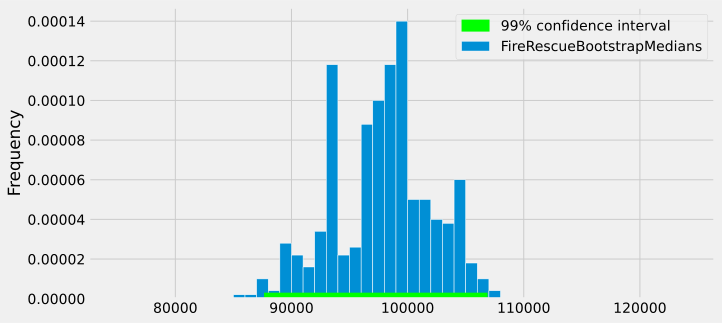

In [36]:
bpd.DataFrame().assign(FireRescueBootstrapMedians=fire_rescue_medians).plot(kind='hist', density=True, bins=np.arange(75000, 125000, 1000), ec='w', figsize=(10, 5))
plt.plot([fire_left, fire_right], [0, 0], color='lime', linewidth=12, label='99% confidence interval');
plt.legend();

In [37]:
# Actual population median of Fire-Rescue Department salaries
fire_rescue_population.get('TotalWages').median()

96873.5

## Mean and median

<center><h3>What is the "center" of a distribution?</h3></center>

### The mean (i.e. average)

The mean of the data

$$2, 3, 3, 9$$

is

$$\rm{mean} = \frac{2 + 3 + 3 + 9}{4} = 4.25$$

### The mean (i.e. average)

The mean of a set of data points can be thought of as a "one-number summary". It... 

- doesn't have to be equal to one of the data points.
- doesn't have to be an integer, even if all of the data points are integers.
- will be somewhere between the min and max, but not necessarily halfway in between.
- has the same units as the data.

### The median

- Like the mean, the median is a "one-number summary" of a set of data points.
- The median is a number in the "middle" of the data.
- To calculate it, **sort the data points and pick the number in the middle**.
    - If there are two middle numbers, we usually pick the number halfway between (i.e. the mean of the middle two).

- **Example:** $\text{Median}(1, 4, 7, 12, 32) = 7$

- **Example:** $\text{Median}(1, 4, 7, 12) = 5.5$

### You Try:

Create a data set that has this histogram. (You can do it with a short list of whole numbers.)

<br>
<center><img src='data/df_A.png' width=450></center>
<br>

What are its mean and median?

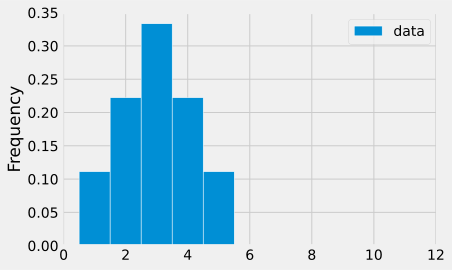

In [41]:
numbers = [1, 2, 2, 3, 3, 3, 4, 4, 5]
bpd.DataFrame().assign(data=numbers).plot(kind='hist', bins=np.arange(0.5, 12.5), density=True, ec='w');

In [42]:
np.mean(numbers)

3.0

In [43]:
np.median(numbers)

3.0

### Example: Flight Delays ✈️

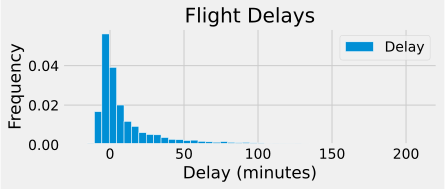

In [47]:
delays = bpd.read_csv('data/delays.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(6, 2))
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)');

**Question:** Which is larger – the mean or the median?

In [48]:
delays.get('Delay').mean()

16.658155515370705

In [49]:
delays.get('Delay').median()

2.0

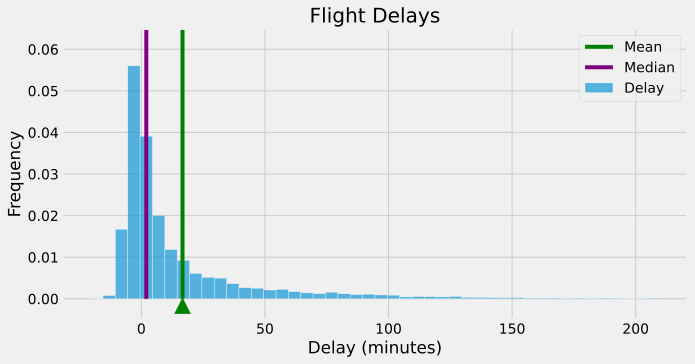

In [50]:
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', alpha=0.65, figsize=(10, 5))
plt.plot([delays.get('Delay').mean(), delays.get('Delay').mean()], [0, 1], color='green', label='Mean')
plt.scatter([delays.get('Delay').mean()], [-0.0017], color='green', marker='^', s=250)
plt.plot([delays.get('Delay').median(), delays.get('Delay').median()], [0, 1], color='purple', label='Median')
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)')
plt.ylim(-0.005, 0.065)
plt.legend();

### Comparing the mean and median
- **Mean:** Balance point of the histogram.
    - Numerically: the sum of the differences between all data points and the mean is 0.
    - Physically: Think of a see-saw.
- **Median:** Half-way point of the data.
    - Half of the area of a histogram is to the left of the median, and half is to the right.
- If the distribution is symmetric about a value, then that value is both the mean and the median.
- If the distribution is **skewed**, then the mean is pulled away from the median in the direction of the tail.

- **Key property:** The median is more **robust** (less **sensitive**) to **outliers**.

### Example: Net Worth 💰

Suppose we have the net worth of all UCSD students.

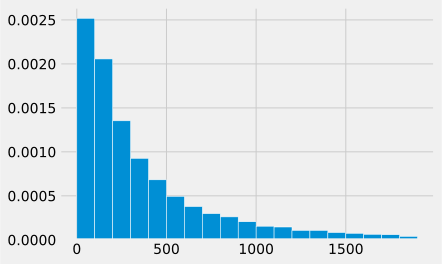

In [51]:
worths = np.random.lognormal(5.5, 1.25, 20_000)
plt.hist(worths, bins=np.arange(0, 2_000, 100), density=True, ec='w');

In [52]:
np.mean(worths)

550.2985620339539

In [53]:
np.median(worths)

247.663416025016

Suppose that LeBron James enrolls at UCSD as a Data Science major. Per [Forbes](https://bleacherreport.com/articles/10014995-forbes-lebron-james-net-worth-close-to-1b-to-break-nba-earnings-record-this-year), his net worth is close to one billion dollars.

In [54]:
new_worths = np.append(worths, 10 ** 9)

In [55]:
np.mean(new_worths)

50547.771173475274

In [56]:
np.median(new_worths)

247.67700245769151

The mean net worth is now over 50 thousand dollars, while the median is unchanged!

## Standard deviation

### Question: How "wide" is a distribution? 

- **One idea:** “biggest value - smallest value” (known as the **range**).
    - Issue: this doesn’t tell us much about the shape of the distribution.

- **Another idea:** "standard deviation".
    - The mean is at the center. 
    - The standard deviation quantifies how far the data points typically are from the center.

### Deviations from the mean

In [57]:
data = np.array([2, 3, 3, 9])

In [58]:
np.mean(data)

4.25

In [59]:
deviations = data - np.mean(data)
deviations

array([-2.25, -1.25, -1.25,  4.75])

### What is the average deviation?

In [60]:
deviations

array([-2.25, -1.25, -1.25,  4.75])

In [61]:
np.mean(deviations)

0.0

- As was mentioned before, this is true of any dataset – the average deviation from the mean is 0.
- This implies that the average deviation itself is not useful in measuring the spread of data.

### Average **squared** deviation

In [62]:
# Square all the deviations
deviations ** 2

array([ 5.06,  1.56,  1.56, 22.56])

In [63]:
variance = np.mean(deviations ** 2)
variance

7.6875

This quantity, the average squared deviation from the mean, is called the **variance**.

### Standard deviation

- Our data usually has units, e.g. dollars.
- The variance is in "squared" units, e.g. $\text{dollars}^2$.
- To account for this, we can take the square root of the variance, and the result is called the **standard deviation**.

In [64]:
# Standard Deviation (SD) is the square root of the variance
sd = variance ** 0.5
sd

2.7726341266023544

### Standard deviation

- The standard deviation (SD) measures roughly how far the data are from their average.
    - Larger SD = more spread out.
- Standard deviation has the same units as the original data.
- `numpy` has a function, `np.std`, that calculates the standard deviation for us.

In [65]:
np.std(data)

2.7726341266023544

### Variance and standard deviation

To summarize:

$$\text{variance} = \text{average squared deviation from the mean} = \frac{(\text{value}_1 - \text{average})^2 + (\text{value}_2 - \text{average})^2 + ... + (\text{value}_n - \text{average})^2}{n}$$

$$\text{standard deviation} = \sqrt{\text{variance}}$$

where $n$ is the number of observations.

### What can we do with the standard deviation?

It turns out, no matter what the shape of the distribution is, the bulk of the data are in the range “average ± a few SDs”.

### Chebyshev’s inequality

**Fact:** No matter what the shape of the distribution is, the proportion of values in the range “average ± z SDs” is at least 

$$1 - \frac{1}{z^2}$$

### Chebyshev's inequality

|Range|Proportion|
|---|---|
|average ± 2 SDs|	at least $1 - \frac{1}{4}$   (75%)|
|average ± 3 SDs|	at least $1 - \frac{1}{9}$   (88.888…%)|
|average ± 4 SDs|	at least $1 - \frac{1}{16}$ (93.75%)|
|average ± 5 SDs|	at least $1 - \frac{1}{25}$  (96%)|

No matter what the distribution is! 

### Example: NBA 🏀

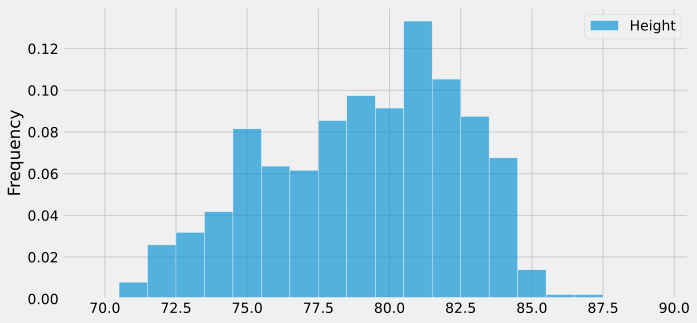

In [66]:
nba = bpd.read_csv('data/nba.csv')
nba.plot(kind='hist', y='Height', density=True, bins=np.arange(69.5, 90, 1), ec='w', figsize=(10, 5), alpha=0.65);

In [67]:
mean = nba.get('Height').mean()
sd = np.std(nba.get('Height'))
print('mean:\t\t\t%f' % mean, 
      '\nstandard deviation:\t%f' % sd)

mean:			79.065347 
standard deviation:	3.450597


### Mean and standard deviation

For this data, mean is about 79 and the SD is about 3.5. By Chebyshev's inequality...

- **At least** 75% of the data is in $$[\text{Mean} - 2 \cdot \text{SD}, \text{Mean} + 2 \cdot \text{SD}] = [79 - 2\cdot 3.5,\, 79 + 2\cdot 3.5] = [72, 86]$$
- **At least** 88% of the data is in $$[\text{Mean} - 3 \cdot \text{SD}, \text{Mean} + 3 \cdot \text{SD}] = [79 - 3\cdot 3.5,\, 79 +3\cdot 3.5] = [68.5, 89.5]$$

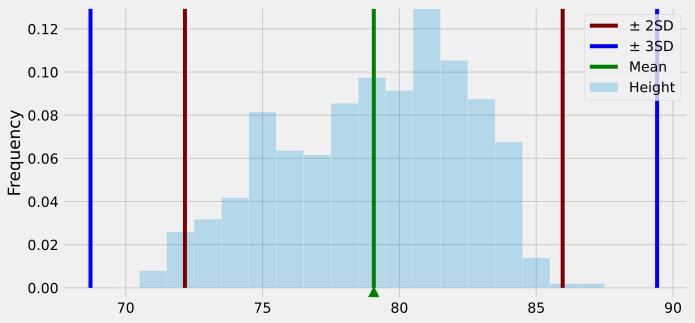

In [68]:
nba.plot(kind='hist', y='Height', density=True, bins=np.arange(69.5, 90, 1), ec='w', figsize=(10, 5), alpha=0.25);
plt.plot([mean-2*sd, mean-2*sd], [0, 0.13], color='maroon', label="± 2SD")
plt.plot([mean+2*sd, mean+2*sd], [0, 0.13], color='maroon')
plt.plot([mean-3*sd, mean-3*sd], [0, 0.13], color='blue', label="± 3SD")
plt.plot([mean+3*sd, mean+3*sd], [0, 0.13], color='blue')
plt.plot([mean, mean], [0, 1], color='green', label='Mean')
plt.scatter([mean], [-0.003], color='green', marker='^', s=250)
plt.ylim(-0.005, 0.13)
plt.legend();

### Chebyshev's inequality

- Chebyshev's inequality works for **any** distribution.
- But if we know the type of the distribution (e.g., normal), we can say more!
    - More on this next time.

### You Try: 

For a particular set of data points, Chebyshev's inequality states that at least $\frac{3}{4}$ of the data points are between 30 and 90. What is the standard deviation of the data?

*Write your answer here*

## Why does it matter?

- It's all connected:
    - Confidence intervals and hypothesis testing are two sides of the same coin.
- Mean, SD, and median are used all the time in science.
    - SD is a useful way to summarize spread.